<a href="https://colab.research.google.com/github/jgarcia2411/Energy-Supply-Smart-Home/blob/main/GA_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns 
import time 
from datetime import datetime
from pandas import concat
from random import random
import random

import numpy as np 
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Flatten
from keras.models import Model


from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from scipy.stats import bernoulli
np.random.RandomState(1234)

sns.set_style('darkgrid')

In [2]:
drive.mount('/data/')#, force_remount= True)
data_dir = '/data/My Drive/EMSE 6575 Final Project'
!ls '/data/My Drive/EMSE 6575 Final Project'

Mounted at /data/
 Datasets
 ExploratoryDataAnalysis.ipynb
"Final Project ToDo's.gdoc"
'GA Optimization.ipynb'
'Medium post draft.gdoc'
 ProjectGoals.gdoc
'Project ideas'
'Project Proposal: Training Schedule.gslides'
 re_sampled.csv
'The Big Book of Machine Learning Use Case-2.pdf'
 Training_sessions.ipynb
 training_update.ipynb
'Untitled drawing.gdraw'


In [4]:
re_dataset = pd.read_csv(data_dir+'/re_sampled.csv', index_col=0)
re_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8399 entries, 2016-01-01 05:00:00 to 2016-12-16 03:00:00
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         8399 non-null   float64
 1   humidity            8399 non-null   float64
 2   visibility          8399 non-null   float64
 3   pressure            8399 non-null   float64
 4   wind_speed          8399 non-null   float64
 5   cloud_cover         8399 non-null   float64
 6   wind_bearing        8399 non-null   float64
 7   precip_probability  8399 non-null   float64
 8   weather_like        8399 non-null   object 
 9   sky_like            8399 non-null   object 
 10  power_generation    8399 non-null   float64
 11  dishwasher          8399 non-null   float64
 12  furnance            8399 non-null   float64
 13  home_office         8399 non-null   float64
 14  fridge              8399 non-null   float64
 15  wine_cellar         8399 no

In [5]:
use_features = ['temperature', 'humidity', 'visibility', 'pressure', 'wind_speed', 'cloud_cover', 'wind_bearing', 'precip_probability', 'weather_like', 'sky_like', 'power_demand']
re_dataset= re_dataset[use_features]

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
  
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
   cols.append(df.shift(i))
   names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
   # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
	# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg
  

In [7]:
values = re_dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,8] = encoder.fit_transform(values[:,8])
values[:,9] = encoder.fit_transform(values[:,9])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
# frame as supervised learning
one_hour = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
one_hour.drop(one_hour.columns[[range(11,21)]], axis=1, inplace=True)
#print(reframed.head())
# frame as supervised learning one day forecast
one_day = series_to_supervised(scaled,24,24)
one_day.drop(one_day.columns[[range(265,528)]], axis=1, inplace= True)

one_week = series_to_supervised(scaled, 336, 168)
one_week.drop(one_week.columns[[range(3697,5544)]], axis=1, inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index,

In [9]:
def create_train_data(dataset, training_size = 0.7):
  """This function takes a dataset, split into training
  and test, and re-shape it in a 3 dimension shape"""
  
  values = dataset.values
  training_hours = int(350*24*training_size)
  # slice training and test hours
  train = values[:training_hours, :] 
  test = values[training_hours:, :]
  # select features and target
  train_X, train_y = train[:,:-1], train[:, -1] 
  test_X, test_y = test[:,:-1], test[:,-1]
  # reshape into 3 dimension dataset
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  return train_X, test_X, train_y, test_y

In [13]:
train_X, test_X, train_y, test_y = create_train_data(one_day, training_size = 0.7)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5880, 1, 264) (5880,) (2472, 1, 264) (2472,)


In [ ]:
#values = re_dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,8] = encoder.fit_transform(values[:,8])
#values[:,9] = encoder.fit_transform(values[:,9])
# ensure all data is float
#values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
# frame as supervised learning
#reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[range(11,21)]], axis=1, inplace=True)
#print(reframed.head())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [ ]:
# split into train and test sets
#values = reframed.values
# our dataset contains 350 days in one hour resolution
# lets train with 70% of that data: 5897 hours
#n_train_hours = 5879
#train = values[:n_train_hours, :]
#test = values[n_train_hours:, :]

# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
#test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]: this is required for the LSTM model :/
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5879, 1, 11) (5879,) (2519, 1, 11) (2519,)


# **Genetic algorithm to optimize hyperparameters**
http://aqibsaeed.github.io/2017-08-11-genetic-algorithm-for-optimizing-rnn/


https://github.com/aqibsaeed/Genetic-Algorithm-RNN

In [ ]:
values = reframed.values
# our dataset contains 350 days in one hour resolution
# lets train with 70% of that data: 5897 hours
n_train_hours = 5879
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]: this is required for the LSTM model :/
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5879, 1, 11) (5879,) (2519, 1, 11) (2519,)


In [12]:
import random 
from random import shuffle, sample

class lstmGA():

    def __init__(
        self,
        x_train,
        y_train,
        x_test,
        y_test,
        population_size=10,
        num_iter=50,
        keep_top_n= 0.5,
        mutation_rate=0.5):

        self.population_size = population_size
        self.num_iter = num_iter
        self.keep_top_n = keep_top_n
        self.mutation_rate = mutation_rate
        self._iteration_progress = []
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        

        #create a initial starting popultaion
        self.starting_states = self._generate_start_state()
    
    def _generate_start_state(self):
        final_population = []
        for _ in range(self.population_size):
            epochs = random.randrange(10,500,100)
            batch_size = random.randrange(0,501,20)
            n_units = random.randrange(10,201,10)
            learning_rate = random.uniform(0.00001, 0.2)
            dropout = random.uniform(0,0.4)
            final_population.append([epochs, batch_size, n_units, learning_rate, dropout])
        return final_population
    
    def _evaluate(self,individual):

        model=Sequential()
        model.add(LSTM(
            int(individual[2]),
            input_shape=(self.x_train.shape[1], self.x_train.shape[2])
        ))
        model.add(LeakyReLU(alpha=0.5))
        model.add(Dropout(individual[-1]))
        model.add(Dense(1))
  
        adam = Adam(lr= individual[3])
        # Stop training when a loss function is not improving
        model.compile(loss='mse', optimizer='adam', metrics = ['mse'])
        model.fit(
            self.x_train, 
            self.y_train, 
            epochs=int(individual[0]), 
            batch_size=int(individual[1]), 
            validation_data=(self.x_test, self.y_test), 
            verbose=0, #2
            shuffle=False )

        results = model.evaluate(
            x=self.x_test,
            y=self.y_test,
            verbose=0, #1
            return_dict=True,
        )
        return results
    
    def evaluate(self, final_population):
        fitness_results = []
        for individual in final_population:
          metrics = self._evaluate(individual)
          fitness_results.append(metrics['mse'])
        return fitness_results

    def reduce_population(self, population, fitness_results):
        #Sort the results and get the indices
        # in order to get the right population rows
        sorted_indices = np.argsort(fitness_results)
        # Determine how many top population members
        # to keep based on if 'keep_top_n' is a float
        # or an integer
        if isinstance(self.keep_top_n, float):
            top_n = max(int(self.keep_top_n*len(fitness_results)),1)
        else:
            top_n= keep_top_n
        final_indices = sorted_indices[:top_n]

        #Pull the appropiate population rows
        reduced_population = np.array(population)[final_indices].tolist()
    
        return reduced_population
    
    def crossover(self,reduced_population, r_cross=0.6):
        #This function crossover two parents to create two children
        parents = sample(reduced_population,2) #list of tuples, each tuple represent two parents
        # parents will have 2 children and will be stored in offpring:
        c1 = parents[0]
        c2= parents[1]
               
        if np.random.rand() < r_cross:
          #select crossover point that is not on the end of the string
          pt = np.random.randint(1, len(parents[0])-2)
          #perform crossover
          c1= parents[0][:pt] + parents[1][pt:]
          c2 = parents[1][:pt] + parents[0][pt:]
        offspring_list= [c1,c2]
        return offspring_list

    def _mutate(self, offspring_list):
        for individual in offspring_list:
            for i in range(len(individual)):
                #check for a mutation
                if np.random.rand() < self.mutation_rate:
                    #mutate randomly
                    if i < 3:
                      individual[i] = int(random.choice([0.5,1,1.5])*individual[i])
                    else:
                      individual[i] = random.choice([0.5,1,1.5])*individual[i]
        return offspring_list
    
    def procreate(self, reduced_population):
        reduced_population_size = len(reduced_population)
        new_population = []

        while len(new_population) < self.population_size - reduced_population_size:
            new_population.extend(self.crossover(reduced_population))
        new_population = self._mutate(new_population)
        return new_population

    def optimize(self, verbose=False):
        'Run the optimization algorithm'
        best_mse = 1E10
        best_sequence =[]

        #Optimize using genetic algorithm
        for i in range(self.num_iter):
            if verbose:
                print(f'OPTIMIZING ROUND {i +1}/{self.num_iter}'.center(100,'='))
            # We want to make sure to keep population size the same
            # so we only pull the las 'population_size' rows.
            if verbose:
                 print('Procreating...')
            starting_idx = -self.population_size
            population =(
                self.starting_states if i == 0 # randomly generates a starting population.
                else self.procreate(reduced_population)#[starting_idx:]
            )
            # Evaluate sequences
            if verbose:
                print('Evaluating...')
            fitness_results = self.evaluate(population) # list of the mse results from LSTM algorithm (fitness function)

            #Sort the results and get best resulting index
            best_idx = np.argsort(fitness_results)[0] # select the best individual

            # Get best mse and sequence
            iter_best = fitness_results[best_idx] 
            is_better = iter_best < best_mse # compare with the last best result and keep it if the mse is lower than the previous.
            best_mse = iter_best if is_better else best_mse # take the new best mse value
            best_sequence = self.starting_states[best_idx] if is_better else best_sequence # select the best individual from starting_states

            # Reduce the population to best
            if verbose:
                print('Selecting best...')
            reduced_population = self.reduce_population(population, fitness_results)

            # Add iteration results to internal results tracker
            self._iteration_progress.append(best_mse)

            if verbose:
                #print best result of this iteration
                print(f'Best mse achieved: {best_mse} - {best_sequence}')
                print('='*100)
        print(f'Best Overall:{best_mse} - {best_sequence}')

        #Generate graph of optimization progress.
        fig, ax = plt.subplots()
        sns.lineplot(
            x = range(1, len(self._iteration_progress) + 1),
            y = self._iteration_progress,
            ax=ax
        );
        ax.set_title('MSE vs Iteration Number')
   

In [ ]:
GA = lstmGA(
    train_X,
    train_y,
    test_X,
    test_y,
    population_size=50,
    num_iter=10,
    keep_top_n=0.5,
    mutation_rate=0.5
)
GA.optimize(verbose=True)

=======================================OPTIMIZING ROUND 1/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.001621018280275166 - [310, 500, 30, 0.13781308249292887, 0.16296967769747284]
=======================================OPTIMIZING ROUND 2/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.0016076765023171902 - [410, 220, 40, 0.17026235883792395, 0.31916867879353855]
=======================================OPTIMIZING ROUND 3/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.0015907027991488576 - [310, 400, 80, 0.199270398324272, 0.35587438970005913]
=======================================OPTIMIZING ROUND 4/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.0015907027991488576 - [310, 400, 80, 0.199270398324272, 0.35587438970005913]
=============

ValueError: ignored

Epoch 1/410
49/49 - 2s - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 2/410
49/49 - 0s - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 3/410
49/49 - 0s - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/410
49/49 - 0s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 5/410
49/49 - 0s - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 6/410
49/49 - 0s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 7/410
49/49 - 0s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/410
49/49 - 0s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 9/410
49/49 - 0s - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 10/410
49/49 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 11/410
49/49 - 0s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 12/410
49/49 

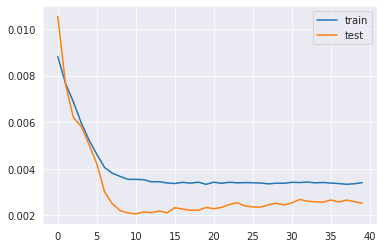

In [ ]:


# design network
units = 180
num_epoch = 410
learning_rate = 0.13300805347894765

model = Sequential()
model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout( 0.2553753845469717))
model.add(Dense(1))

adam = Adam(lr= learning_rate)
# Stop training when a loss function is not improving
callback = [EarlyStopping(monitor='loss', min_delta = 0.00001, patience= 20, mode = 'auto', restore_best_weights=True)]
model.compile(loss='mse', optimizer='adam', metrics = ['mse'])
# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=num_epoch, 
    batch_size=120, 
    validation_data=(test_X, test_y), 
    callbacks = callback, 
    verbose=2, 
    shuffle=False
    )
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.128


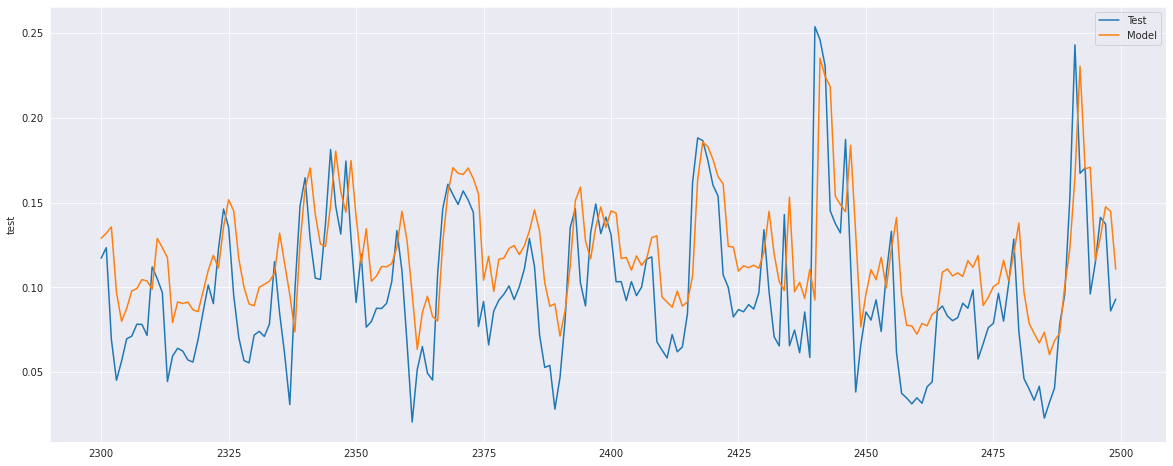

In [ ]:
results = pd.DataFrame()
results['test']= pd.Series(test_y.flatten()) #inv_y
results['model'] = pd.Series(yhat.flatten()) #inv_yhat
fig, ax= plt.subplots(figsize= (20,8))
sns.lineplot(x=results.iloc[2300:2500,:].index,y= results.iloc[2300:2500,0], ax=ax)
sns.lineplot(x=results.iloc[2300:2500,:].index,y= results.iloc[2300:2500,1], ax=ax)
ax.legend(['Test', 'Model'])
plt.show()

# 24 hours - 24 hours

In [ ]:
GA_24 = lstmGA(
    train_X,
    train_y,
    test_X,
    test_y,
    population_size=50,
    num_iter=10,
    keep_top_n=0.5,
    mutation_rate=0.5
)
GA_24.optimize(verbose=True)

=======================================OPTIMIZING ROUND 1/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.0011476854560896754 - [110, 60, 110, 0.08325015575340167, 0.08547828561591304]
=======================================OPTIMIZING ROUND 2/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.0011475668288767338 - [10, 340, 120, 0.0801614493837312, 0.07916561612202094]
=======================================OPTIMIZING ROUND 3/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.0011475668288767338 - [10, 340, 120, 0.0801614493837312, 0.07916561612202094]
=======================================OPTIMIZING ROUND 4/10========================================
Procreating...
Evaluating...
Selecting best...
Best mse achieved: 0.0011475668288767338 - [10, 340, 120, 0.0801614493837312, 0.07916561612202094]
===========